Install python dev tools and dask dataframes.

In [ ]:
!pip install colab-dev-tools
!python -m pip install "dask[dataframe]"

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 7

Get flight data tar from my drive.

In [ ]:
!gdown '1Ms9cVOIsf-Thr_ZDPLyjkXufQaB7NBJQ'

Downloading...
From (original): https://drive.google.com/uc?id=1Ms9cVOIsf-Thr_ZDPLyjkXufQaB7NBJQ
From (redirected): https://drive.google.com/uc?id=1Ms9cVOIsf-Thr_ZDPLyjkXufQaB7NBJQ&confirm=t&uuid=73105003-a152-4025-b329-499e2f5c99fb
To: /content/all_flight.tar.gz
100% 4.29G/4.29G [01:03<00:00, 67.9MB/s]


extract.

In [ ]:
import tarfile
_ = tarfile.open('all_flight.tar.gz').extractall('')

Clone the causal jazz repo.

In [ ]:
!git clone https://github.com/hugh-osborne/causaljazz.git

Cloning into 'causaljazz'...
remote: Enumerating objects: 905, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 905 (delta 57), reused 63 (delta 29), pack-reused 812
Receiving objects: 100% (905/905), 685.17 KiB | 2.80 MiB/s, done.
Resolving deltas: 100% (474/474), done.


Move to the repo home directory.

In [ ]:
import os
os.chdir('causaljazz')
!git pull

Already up to date.


Manually install causal jazz. At some point we'll publish to pypi.

In [ ]:
!pip install .
os.chdir('..')

Processing /content/causaljazz
  Preparing metadata (setup.py) ... done
  Created wheel for causaljazz: filename=causaljazz-0.0.1-py3-none-any.whl size=15806 sha256=9a65138e35105afd655cd2211f036150db7d27230b4563140ca23726ebbb23eb
  Stored in directory: /tmp/pip-ephem-wheel-cache-uu48o17w/wheels/b0/cd/89/3c771fb62baa20238264eb575d880299443d3de8a05d293808
Successfully built causaljazz


Run the example. Note, to begin with, set generate_models = True so that the model can be learned (later we can save the files.). Once the files have been generated, set it to false for repeat runs to save time.

Imports.

In [ ]:
import pandas as pd
import dask.dataframe as dd

import numpy as np
import matplotlib.pyplot as plt
import math

from causaljazz.visualiser import Visualiser
from causaljazz.inference import TEDAG
from causaljazz.inference import TEDAG_FUNCTION
from causaljazz.cpu import pmf
from causaljazz.cpu import transition

import tensorflow as tf
from tensorflow.keras import layers

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


Define some tensorflow model classes to be used later.


In [ ]:
# Class to learn a constant variance (with constant input val[0]) between the expected value val[1] and the predicted value val[2]
class NoiseModel(tf.keras.Model):
    def __init__(self, inputs, var_model, **kwargs):
        super().__init__(inputs, **kwargs)
        self.var_model = var_model
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            vals = []
            for d in data[0]:
                vals = vals + [d]

            var_model_z = self.var_model([vals[0]])
            loss = tf.reduce_sum(tf.keras.losses.mean_squared_error((vals[2]-vals[1])*(vals[2]-vals[1]), var_model_z))

            total_loss = loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(loss)
        return {
            "loss": self.total_loss_tracker.result(),
        }

# Autoencoder class to learn throttle - possibly this can be generalised?
class ThrottleModel(tf.keras.Model):
    def __init__(self, inputs, throttle_encoder, throttle_decoder, **kwargs):
        super().__init__(inputs, **kwargs)
        self.throttle_encoder = throttle_encoder
        self.throttle_decoder = throttle_decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            vals = []
            for d in data[0]:
                vals = vals + [d]

            throttle_encoder_z = self.throttle_encoder([vals[1], vals[2], vals[0], vals[3]])
            throttle_decoder_z = self.throttle_decoder([throttle_encoder_z, vals[1], vals[2], vals[3]])
            loss = tf.reduce_sum(tf.keras.losses.mean_squared_error(vals[0], throttle_decoder_z))

            total_loss = loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(loss)
        return {
            "loss": self.total_loss_tracker.result(),
        }

# class to learn the timescale 'a' of a derivative where dx/dt = a*(stationary - x)
# The timescale is constant and has the constant input 1 (vals[3])
# vals[0] : predicted stationary value
# vals[1] : current actual or predicted value
# vals[2] : actual dx/dt (in our case the diff between two timepoints)
# vals[3] : constant ones
class DerivModel(tf.keras.Model):
    def __init__(self, inputs, ts_model, **kwargs):
        super().__init__(inputs, **kwargs)
        self.ts_model = ts_model
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            vals = []
            for d in data[0]:
                vals = vals + [d]

            ts_model_z  = self.ts_model([vals[3]])
            loss = tf.reduce_sum(tf.keras.losses.mean_absolute_error(tf.abs(vals[2]),(tf.multiply(ts_model_z,tf.abs(vals[0] - vals[1])))))

            total_loss = loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        return {
            "loss": self.total_loss_tracker.result(),
        }

Now some helper functions...

In [ ]:
def build_pmf(sample, num_intervals = 100):
  vmin = np.min(sample)
  vmax = np.max(sample)

  if vmax-vmin == 0:
      vmin -= 0.005
      vmax += 0.005

  # Build a pmf for each latent variable
  num_points = sample.shape[0]
  mass_per_point = 1.0 / num_points
  interval_width = (vmax-vmin)/num_intervals
  pmf = np.zeros(num_intervals+1)
  for i in sample:
      idx = int((i - vmin) / interval_width)
      pmf[idx] += mass_per_point

  return pmf

def build_cmf(pmf, num_intervals = 100):
  # build cmfs for sampling
  cmf = np.zeros(num_intervals+1)
  mass = 0.0
  for i in range(num_intervals+1):
      mass += pmf[i]
      cmf[i] = mass

  return cmf

def sample_from_cmf(cmf, num_points, vmin, vmax, num_intervals = 100):
  interval_width = (vmax-vmin)/num_intervals

  noise_rand = np.array([np.random.uniform() for a in range(num_points)])

  noise_sampled = np.zeros(num_points)
  for et in range(num_points):
      for i in range(num_intervals+1):
          if noise_rand[et] < cmf[i]:
              noise_sampled[et] = vmin + (i * interval_width) + (interval_width * np.random.uniform())
              break

  return noise_sampled

# get the data we care about for all flights for a given timestep
def getFlightDataAtTimestep(dataset, current_timestep):
  if current_timestep == 0:
      current_timestep = 1

  training_data = []

  current_t = dataset[dataset['timestep'] == current_timestep]
  current_t = current_t[['E1 RPM', 'E1 EGT1', 'E1 FFlow', 'VSpd', 'AltMSL', 'IAS', 'E1 OilP']]
  previous_t = dataset[dataset['timestep'] == current_timestep-1]
  previous_t = previous_t[['E1 RPM', 'E1 EGT1']]

  # Loop through all flights up the max we want to view
  flight_count = 0

  for flight_index in [a for a in current_t.index]:
      if flight_count > max_flights:
          continue
      flight_count += 1

      if flight_index not in [a for a in current_t.index] or flight_index not in [a for a in previous_t.index]:
          continue

      vals_t = current_t.loc[flight_index].to_numpy().tolist()
      vals_prev_t = previous_t.loc[flight_index].to_numpy().tolist()

      # For the two variables we want, if either are NaN, just ignore this data point.
      if (np.any([math.isnan(x) for x in vals_t]) or np.any([math.isnan(x) for x in vals_prev_t])):
          continue

      #                                  'E1 RPM', 'E1 EGT1', 'E1 FFlow',  'VSpd',   'AltMSL',   'IAS'             'dRPM',                       'dEGT'             'OilP'
      training_data = training_data + [[vals_t[0], vals_t[1], vals_t[2], vals_t[3], vals_t[4], vals_t[5], vals_t[0] - vals_prev_t[0], vals_t[1] - vals_prev_t[1], vals_t[6]]]

  return training_data

def normaliseAndFormatData(data):
  data = ((np.array(data)-min_vals) / max_vals) - 0.5
  data_items = []
  for d in range(data.shape[1]):
      data_items = data_items + [np.reshape(data[:,d], [data[:,d].shape[0],1])]
  return data_items

# If we want to generate a pmf from a sample of points, we can use this function to get the desired cell widths
def calculateCellGridMetrics(data, res):
    in_mins = np.min(data, axis=1)
    in_maxs = np.max(data, axis=1)
    in_ranges = in_maxs - in_mins
    in_ranges = np.array([r if r > 0 else 0.00001 for r in in_ranges]) # make sure no range is zero and give it a small epsilon range if so
    return in_mins, in_maxs, in_ranges, np.divide(in_ranges,res)

Now load the data. This takes some time but luckily only needs to be called once then later processing can be repeated - the magic of iPython!

In [ ]:
observed_variables = ['E1 RPM', 'IAS', 'E1 FFlow', 'E1 EGT1', 'AltMSL', 'VSpd', 'E1 OilP'] # In the future, add all four EGTs?

# Define a maximum number of timesteps and flights to load
max_flights = 500
max_num_timesteps = 200

# Load the flight header info
flight_header_df = pd.read_csv('all_flights/flight_header.csv', index_col='Master Index')
# Optionally search only for flights corresponding to a specific maintenance label
flight_header_df = flight_header_df[flight_header_df['label'].str.contains('oil')]

# Split flights into those before maintenance and after maintenance
after_flights = flight_header_df[flight_header_df['number_flights_before'] == -1].index # -1 == flight after
before_flights = flight_header_df[flight_header_df['number_flights_before'] == 0].index # >=0 == flight before

# Load the flight data - to speed things up, only select the two (or more) variabels we care about olus timestep
all_interested_columns = observed_variables + ['timestep']
flight_data_ddf = dd.read_parquet('all_flights/one_parq', columns=all_interested_columns, index_col='Master Index')

# Using the header data, split the flight data into before and after maintenance flights
# Only read timesteps below the max required
indices = [a for a in after_flights]
flight_data_ddf_after = flight_data_ddf.loc[flight_data_ddf.index.isin(indices)]
flight_data_ddf_after = flight_data_ddf_after.loc[flight_data_ddf_after['timestep'] < max_num_timesteps]
flight_data_ddf_after = flight_data_ddf_after.loc[flight_data_ddf_after['AltMSL'] > 200] # avoid planes at ground level
flight_data_df_after = flight_data_ddf_after.compute()

indices = [a for a in before_flights]
flight_data_ddf_before = flight_data_ddf.loc[flight_data_ddf.index.isin(indices)]
flight_data_ddf_before = flight_data_ddf_before.loc[flight_data_ddf_before['timestep'] < max_num_timesteps]
flight_data_ddf_before = flight_data_ddf_before.loc[flight_data_ddf_before['AltMSL'] > 200]
flight_data_df_before = flight_data_ddf_before.compute()

Format the data into a nice structure. See getFlightDataAtTimestep for the order of variables.

In [ ]:
training_data_after = []
# load training data for flights after maintenance
for current_timestep in [a+1 for a in range(max_num_timesteps-1)]:
    training_data_after = training_data_after + getFlightDataAtTimestep(flight_data_df_after, current_timestep)

min_vals = np.min(training_data_after, axis=0)
max_vals  = np.max(training_data_after, axis=0)
training_data_after = ((np.array(training_data_after)-min_vals) / max_vals) - 0.5

training_data_before = []
# load training data for flights before maintenance
for current_timestep in [a+1 for a in range(max_num_timesteps-1)]:
    training_data_before = training_data_before + getFlightDataAtTimestep(flight_data_df_before, current_timestep)

training_data_before = ((np.array(training_data_before)-min_vals) / max_vals) - 0.5



Now define the different tensorflow models and train them if required.

In [ ]:
generate_models = True

# Inputs must be separate because we're going to concatenate it
rpm_input = tf.keras.Input(shape=(1))
rpm_diff_input = tf.keras.Input(shape=(1))
rpm_static_input = tf.keras.Input(shape=(1))
fflow_input = tf.keras.Input(shape=(1))
egt1_input = tf.keras.Input(shape=(1))
egt1_diff_input = tf.keras.Input(shape=(1))
egt1_static_input = tf.keras.Input(shape=(1))
vspd_input = tf.keras.Input(shape=(1))
constant_input = tf.keras.Input(shape=(1))
ias_input = tf.keras.Input(shape=(1))
alt_input = tf.keras.Input(shape=(1))
oilp_input = tf.keras.Input(shape=(1))

error = 100

# This is the encoder part of an autoencoder to guess what throttle should be based on all inputs into fflow (and fflow itself)
throttle_encoder_concat = layers.Concatenate(axis=1)([ias_input, alt_input, fflow_input, rpm_input])
throttle_encoder_z = layers.Dense(200)(throttle_encoder_concat)
throttle_encoder_z = layers.Dense(200)(throttle_encoder_z)
throttle_encoder_z = layers.Dense(1)(throttle_encoder_z)
throttle_encoder = tf.keras.Model([ias_input, alt_input, fflow_input, rpm_input], throttle_encoder_z, name="throttle_enc")
throttle_encoder.summary()

# The decoder part of the throttle autoencoder is the function to calculate fflow
throttle_decoder_concat = layers.Concatenate(axis=1)([throttle_encoder_z, ias_input, alt_input, rpm_input])
throttle_decoder_z = layers.Dense(200)(throttle_decoder_concat)
throttle_decoder_z = layers.Dense(200)(throttle_decoder_z)
throttle_decoder_z = layers.Dense(1)(throttle_decoder_z)
throttle_decoder = tf.keras.Model([throttle_encoder_z, ias_input, alt_input, rpm_input], throttle_decoder_z, name="throttle_dec")
throttle_decoder.summary()

# This is the function to calculate the expected value of EGTStat. We will add noise to this later.
egt_stat_concat = layers.Concatenate(axis=1)([fflow_input, rpm_input])
egt_stat_z = layers.Dense(200)(egt_stat_concat)
egt_stat_z = layers.Dense(200)(egt_stat_z)
egt_stat_z = layers.Dense(1)(egt_stat_z)
egt_stat = tf.keras.Model([fflow_input, rpm_input], egt_stat_z, name="egt_stat")
egt_stat.summary()

# This is the timescale for the change in EGT (dEGTdt) it should be a constant and positive (hence the sigmoid activation)
egt_ts_concat = layers.Concatenate(axis=1)([constant_input])
egt_ts_z = layers.Dense(1, activation='sigmoid')(egt_ts_concat)
egt_ts = tf.keras.Model([constant_input], egt_ts_z, name="egt_ts")
egt_ts.summary()

# This is the variance of EGT from the predicted value of EGTStat
egt_stat_var_concat = layers.Concatenate(axis=1)([constant_input])
egt_stat_var_z = layers.Dense(1)(egt_stat_var_concat)
egt_stat_var = tf.keras.Model([constant_input], egt_stat_var_z, name="egt_stat_var")
egt_stat_var.summary()

# This is the function to estimate OilP (oil pressure) which is dependent on the RPM
oilp_z = layers.Dense(20)(rpm_input)
oilp_z = layers.Dense(1)(oilp_z)
oilp = tf.keras.Model([rpm_input], oilp_z, name="oilp")
oilp.summary()

# This is the variance of OilP from the predicted expected value of OilP
oilp_var_concat = layers.Concatenate(axis=1)([constant_input])
oilp_var_z = layers.Dense(1)(oilp_var_concat)
oilp_var = tf.keras.Model([constant_input], oilp_var_z, name="oilp_var")
oilp_var.summary()


rpm_input_data = np.reshape(training_data_after[:,0], [training_data_after[:,0].shape[0],1])
egt_input_data = np.reshape(training_data_after[:,1], [training_data_after[:,1].shape[0],1])
fflow_input_data = np.reshape(training_data_after[:,2], [training_data_after[:,2].shape[0],1])
vspd_input_data = np.reshape(training_data_after[:,3], [training_data_after[:,3].shape[0],1])
alt_input_data = np.reshape(training_data_after[:,4], [training_data_after[:,4].shape[0],1])
ias_input_data = np.reshape(training_data_after[:,5], [training_data_after[:,5].shape[0],1])
rpm_diff_input_data = np.reshape(training_data_after[:,6], [training_data_after[:,6].shape[0],1])
egt1_diff_input_data = np.reshape(training_data_after[:,7], [training_data_after[:,7].shape[0],1])
oilp_input_data = np.reshape(training_data_after[:,8], [training_data_after[:,8].shape[0],1])
constant_ones = np.ones(training_data_after[:,0].shape)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=20,
                                            restore_best_weights=True)

# Learn the latent variable Throttle and the function to calculate fflow
throttle_model = ThrottleModel([fflow_input, ias_input, alt_input, rpm_input], throttle_encoder, throttle_decoder)
if generate_models:
    print("Throttle/FFlow Training...")
    throttle_model.compile(optimizer=tf.keras.optimizers.Adam())
    throttle_model.fit([fflow_input_data,
                     ias_input_data,
                     alt_input_data,
                     rpm_input_data],
             epochs=200, batch_size=1000, verbose=1, callbacks=[callback])
    throttle_model.save_weights('throttle_model.weights')
else:
    throttle_model.load_weights('throttle_model.weights')

# Learn the OilP values

if generate_models:
    print("OilP Training...")
    oilp.compile(loss='mae', optimizer=tf.keras.optimizers.Adam())
    oilp.fit([rpm_input_data], oilp_input_data, epochs=200, batch_size=1000, verbose=1, callbacks=[callback], validation_split=0.2)
    oilp.save('oilp.model')
else:
    oilp = tf.keras.models.load_model('oilp.model')

oilp_predicted = oilp.predict([rpm_input_data], verbose=0)

# Learn the egt stationary values

if generate_models:
    print("EGT Stationary Training...")
    egt_stat.compile(loss='mae', optimizer=tf.keras.optimizers.Adam())
    egt_stat.fit([fflow_input_data,rpm_input_data], egt_input_data, epochs=200, batch_size=1000, verbose=1, callbacks=[callback], validation_split=0.2)
    egt_stat.save('egt_stat.model')
else:
    egt_stat = tf.keras.models.load_model('egt_stat.model')

egt_stat_predicted = egt_stat.predict([fflow_input_data, rpm_input_data], verbose=0)

# Learn the timescale of dEGTdt
egt_deriv_model = DerivModel([egt1_static_input, egt1_input, egt1_diff_input,constant_input], egt_ts)
if generate_models:
    print("Timescale Training...")
    egt_deriv_model.compile(optimizer=tf.keras.optimizers.Adam())
    egt_deriv_model.fit([egt_stat_predicted,
                     egt_input_data,
                     egt1_diff_input_data,
                     constant_ones],
             epochs=200, batch_size=1000, verbose=1, callbacks=[callback])
    egt_deriv_model.save_weights('egt_ts_model.weights')
else:
    egt_deriv_model.load_weights('egt_ts_model.weights')

# Learn the (assumed) constant variance of EGTStat
egt_noise_model = NoiseModel([constant_input, egt_stat_z, egt1_input], egt_stat_var)
if generate_models:
    print("EGT Noise Training...")
    egt_noise_model.compile(optimizer=tf.keras.optimizers.Adam())
    egt_noise_model.fit([constant_ones,
                     egt_stat_predicted,
                     egt_input_data],
             epochs=200, batch_size=1000, verbose=1, callbacks=[callback])
    egt_noise_model.save_weights('egt_noise_model.weights')
else:
    egt_noise_model.load_weights('egt_noise_model.weights')

# Learn the (assumed) constant variance of OilP
oilp_noise_model = NoiseModel([constant_input, oilp_z, oilp_input], oilp_var)
if generate_models:
    print("OilP Noise Training...")
    oilp_noise_model.compile(optimizer=tf.keras.optimizers.Adam())
    oilp_noise_model.fit([constant_ones,
                     oilp_predicted,
                     oilp_input_data],
             epochs=200, batch_size=1000, verbose=1, callbacks=[callback])
    oilp_noise_model.save_weights('oilp_noise_model.weights')
else:
    oilp_noise_model.load_weights('oilp_noise_model.weights')

Model: "throttle_enc"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_11 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                       

Now we want to build the Causal Jazz simulation. First define the functions of the SCM.

In [ ]:
def prepareDataForPrediction(y):
    y = np.array(y)
    prepared = []
    for d in range(y.shape[1]):
        data = y[:,d]
        data = np.reshape(data, [data.shape[0],1])
        prepared = prepared + [data]

    return prepared

# Estimate the constant timescales to be applied to dRPMdt and dEGTdt in rpm_func and egt_func below
# dEGTdt timescale
egt_ts_predicted = egt_deriv_model.ts_model.predict([constant_ones], verbose=0)
egt_ts_constant = egt_ts_predicted[0,0]

# This is our estimated SCM
def fflow_func(y):
    data = prepareDataForPrediction(y)
    fflow = throttle_model.throttle_decoder.predict(data,verbose=0)
    return np.transpose(np.array([fflow[:,0]]))

def egt_stationary_func(y):
    #data[0] is the noise and is added separately
    data = prepareDataForPrediction(np.array(y)[:,1:])
    noise_data = prepareDataForPrediction(y)
    egt_stat_out = egt_stat.predict(data, verbose=0)
    return np.transpose(np.array([np.array(egt_stat_out[:,0]) + np.array(noise_data)[0,:,0]]))

def egt_func(y):
    data = prepareDataForPrediction(y)
    egt_prime = egt_ts_constant * (np.array(data)[1,:,0] - np.array(data)[0,:,0])
    egt_new = np.array(data)[0,:,0] + egt_prime
    return np.transpose(np.array([egt_new]))

def oilp_func(y):
    #data[0] is the noise and is added separately
    data = prepareDataForPrediction(np.array(y)[:,1:])
    noise_data = prepareDataForPrediction(y)
    oilp_out = oilp.predict(data, verbose=0)
    return np.transpose(np.array([np.array(oilp_out[:,0]) + np.array(noise_data)[0,:,0]]))

trans_fflow_func = transition(fflow_func, 4)
trans_egtstat_func = transition(egt_stationary_func, 3)
trans_egt_func = transition(egt_func, 2)
trans_oilp_func = transition(oilp_func, 2)

Now build the initial distributions. res is the grid resolution of all discretised distributions. As most of the data are normalised, this amounts to a cell width of approximately 0.02.

In [ ]:
res = 50

# From the full data, predict the distribution of throttle and calculate the constant variance for EGTNoise, RPMNoise
# egt_stat_predicted and rpm_stat_predicted have already been generated as they were used to learn RPMNoise and EGTNoise
# dEGTdt timescale and dRPMdt timescale have already been calculated to be used in egt_func and rpm_func

# Throttle
throttle_predicted = throttle_model.throttle_encoder.predict([ias_input_data, alt_input_data, fflow_input_data, rpm_input_data],verbose=0)

# EGTNoise
egt_stat_var_predicted = egt_noise_model.var_model.predict([constant_ones],verbose=0) # Hopefully, noise_encoder has encoded a nice gaussianish variable (not guaranteed at all)
egt_stat_var_constant = egt_stat_var_predicted[0,0]

# OilPNoise
oilp_var_predicted = oilp_noise_model.var_model.predict([constant_ones],verbose=0) # Hopefully, noise_encoder has encoded a nice gaussianish variable (not guaranteed at all)
oilp_var_constant = oilp_var_predicted[0,0]

# Number of points to deal with at a time
num_points = 100

# First, sample num_points values from the throttle distribution
throttle_pmf = build_pmf(throttle_predicted[:,0])
throttle_cmf = build_cmf(throttle_pmf)


# Get the starting data for our observed variables
data_items = normaliseAndFormatData(getFlightDataAtTimestep(flight_data_df_after, 1))
red_ias_input_data = data_items[5][:,0]
red_alt_input_data = data_items[4][:,0]
red_rpm_input_data = data_items[0][:,0]
red_egt_input_data = data_items[1][:,0]
red_oilp_input_data = data_items[8][:,0]
red_egt_stat_predicted = egt_stat_predicted[:,0]

throttle_noise_basic_sampled = sample_from_cmf(throttle_cmf, red_ias_input_data.shape[0], np.min(throttle_predicted), np.max(throttle_predicted))

# The resolution of our grids - right now, we only allow a single value for all dimensions (there's a bug when it's different)


# Build the initial distributions based on the initial data
throttle_noise_pmf = pmf(build_pmf(throttle_noise_basic_sampled,num_intervals=res), np.array([(np.max(throttle_noise_basic_sampled)-np.min(throttle_noise_basic_sampled))/res]), 0.00001)
ias_pmf = pmf(build_pmf(red_ias_input_data,num_intervals=res), np.array([(np.max(red_ias_input_data)-np.min(red_ias_input_data))/res]), 0.00001)
alt_pmf = pmf(build_pmf(red_alt_input_data,num_intervals=res),  np.array([(np.max(red_alt_input_data)-np.min(red_alt_input_data))/res]), 0.00001)
rpm_input_pmf = pmf(build_pmf(red_rpm_input_data,num_intervals=res),np.array([(np.max(red_rpm_input_data)-np.min(red_rpm_input_data))/res]), 0.000001)
egt_input_pmf = pmf(build_pmf(red_egt_input_data,num_intervals=res), np.array([(np.max(red_egt_input_data)-np.min(red_egt_input_data))/res]), 0.000001)
oilp_input_pmf = pmf(build_pmf(red_oilp_input_data,num_intervals=res),  np.array([(np.max(red_oilp_input_data)-np.min(red_oilp_input_data))/res]), 0.00001)

# Build the initial noise dis mributions
egt_stat_noise_points = np.reshape(np.random.normal(loc=0.0,scale=np.sqrt(egt_stat_var_constant), size=100000), (100000))
egt_stat_noise_pmf = pmf(np.array([]), np.array([(np.max(egt_stat_noise_points)-np.min(egt_stat_noise_points))/res]), 0.000001)
egt_stat_noise_points = np.reshape(egt_stat_noise_points, (100000,1))
egt_stat_noise_pmf.generateInitialDistribtionFromSample(egt_stat_noise_points)

oilp_noise_points = np.reshape(np.random.normal(loc=0.0,scale=np.sqrt(oilp_var_constant), size=100000), (100000))
oilp_noise_pmf = pmf(np.array([]), np.array([(np.max(oilp_noise_points)-np.min(oilp_noise_points))/res]), 0.00001)
oilp_noise_points = np.reshape(oilp_noise_points, (100000,1))
oilp_noise_pmf.generateInitialDistribtionFromSample(oilp_noise_points)

# Build template distributions for the remaining variables
fflow_pmf_template = pmf(np.array([1.0]), np.array([(np.max(fflow_input_data)-np.min(fflow_input_data))/res]), 0.000001)
egt_stat_template = pmf(np.array([1.0]), np.array([(np.max(egt_stat_predicted[:,0])-np.min(egt_stat_predicted[:,0]))/res]), 0.000001)
oilp_template = pmf(np.array([1.0]), np.array([(np.max(oilp_input_data[:,0])-np.min(oilp_input_data[:,0]))/res]), 0.000001)
rpm_pmf_template = pmf(np.array([1.0]), np.array([(np.max(rpm_input_data)-np.min(rpm_input_data))/res]), 0.000001)

# Starting distributions for egt and rpm
egt_noise_points = np.reshape(np.random.normal(loc=-0.2,scale=0.05, size=100000), (100000))
egt_noise_pmf = pmf(np.array([]), np.array([1.0/res]), 0.000001)
egt_noise_points = np.reshape(egt_noise_points, (100000,1))
egt_noise_pmf.generateInitialDistribtionFromSample(egt_noise_points)

rpm_noise_points = np.reshape(np.random.normal(loc=0.2,scale=0.05, size=100000), (100000))
rpm_noise_pmf = pmf(np.array([]), np.array([(np.max(rpm_noise_points)-np.min(rpm_noise_points))/res]), 0.000001)
rpm_noise_points = np.reshape(rpm_noise_points, (100000,1))
rpm_noise_pmf.generateInitialDistribtionFromSample(rpm_noise_points)

# Build initial distribution of observed variables and throttle
data_points = np.stack([throttle_noise_basic_sampled, red_alt_input_data, red_ias_input_data, red_rpm_input_data, red_egt_input_data, red_oilp_input_data])
_, _, _, cell_widths = calculateCellGridMetrics(data_points, [res,res,res,res,res,res])
start_pmf = pmf(np.array([]), cell_widths, _mass_epsilon=0.000001)
in_data_points = np.transpose(data_points)
start_pmf.generateInitialDistribtionFromSample(in_data_points)

Define the TEDAG and its TEDAG_FUNCTIONS.
Define any interventions. This should include interventions to set the initial distributions at time 0.

In [ ]:
# Constants
tedag_func_throttle = TEDAG_FUNCTION(['Throttle'], 'Throttle', 1, None, throttle_noise_pmf)
tedag_func_egt_noise = TEDAG_FUNCTION(['EGTNoise'], 'EGTNoise', 1, None, egt_stat_noise_pmf)
tedag_func_oilp_noise = TEDAG_FUNCTION(['OilPNoise'], 'OilPNoise', 1, None, oilp_noise_pmf)

# We're just ignoring changes in IAS, AltMSL, and RPM for now so treat them like constants
tedag_func_ias = TEDAG_FUNCTION(['IAS'], 'IAS', 1, None, ias_pmf)
tedag_func_altmsl = TEDAG_FUNCTION(['AltMSL'], 'AltMSL', 1, None, alt_pmf)
tedag_func_rpm = TEDAG_FUNCTION(['E1 RPM'], 'E1 RPM', 1, None, rpm_pmf_template)

# Functions which are calculated "instantly" : less than a single dt.
tedag_func_fflow = TEDAG_FUNCTION(['Throttle', 'IAS', 'AltMSL', 'E1 RPM'], 'E1 FFlow', 0, trans_fflow_func, fflow_pmf_template)
tedag_func_egt_stat = TEDAG_FUNCTION(['EGTNoise', 'E1 FFlow', 'E1 RPM'], 'EGTStat', 0, trans_egtstat_func, egt_stat_template)
tedag_func_oilp = TEDAG_FUNCTION(['OilPNoise','E1 RPM'], 'E1 OilP', 0, trans_oilp_func, oilp_template)

# Currently we don't store dEGTdt and just calculate it during tedag_func_egt
# but if we wished, we could make it explicit which would be nice to see and also to intervene on
#tedag_func_egt_dt = TEDAG_FUNCTION(['EGTStat', 'E1 EGT1'], 'dEGTdt', 0)

# Functions which are calculated over multiples of dts
tedag_func_egt = TEDAG_FUNCTION(['E1 EGT1', 'EGTStat'], 'E1 EGT1', 1, trans_egt_func, egt_input_pmf)


tedag = TEDAG(1.0, [tedag_func_throttle, tedag_func_egt_noise, tedag_func_ias, tedag_func_rpm,
                    tedag_func_altmsl, tedag_func_fflow, tedag_func_oilp, tedag_func_oilp_noise,
                    tedag_func_egt_stat, tedag_func_egt], ['E1 RPM', 'E1 EGT1'])

tedag.addIntervention(['Throttle','AltMSL','IAS', 'E1 RPM', 'E1 EGT1', 'E1 OilP'], 0, start_pmf)
tedag.addIntervention(['EGTNoise'], 0, egt_stat_noise_pmf)
tedag.addIntervention(['OilPNoise'], 0, oilp_noise_pmf)
tedag.addIntervention(['E1 RPM'], 50, rpm_noise_pmf)

Flags to say what to simulation and plot.

In [ ]:
plot_data_fixed = False
plot_data_issue = True
plot_cj = True

Simulate! Causal sample points are plotted in blue, post-maintenance (fixed) data points in green, and pre-maintenance (issue) data points in red.

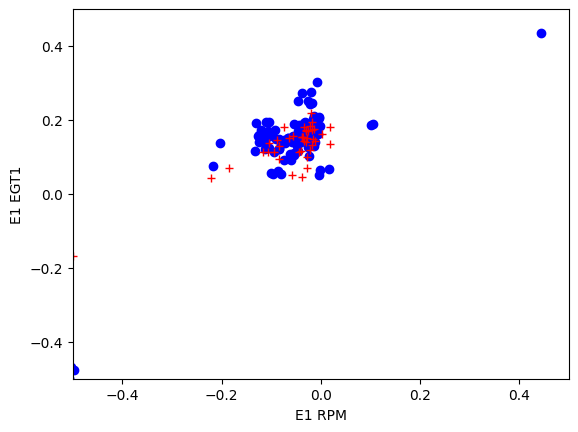

KeyboardInterrupt: 

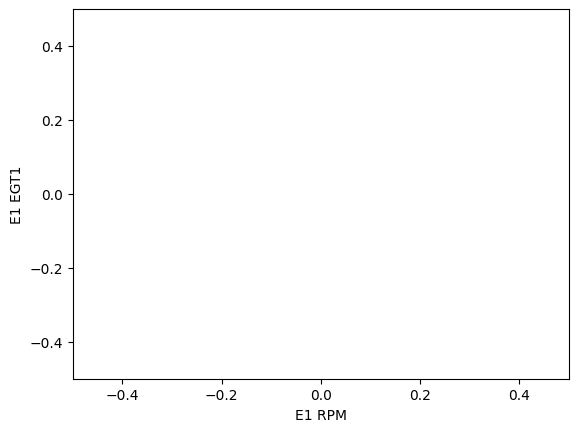

In [ ]:
if plot_data_issue:
  current_timestep_df_before = flight_data_df_before[['E1 RPM', 'E1 EGT1','timestep']]
if plot_data_fixed:
  current_timestep_df_after = flight_data_df_after[['E1 RPM', 'E1 EGT1','timestep']]

vis_key_inds = [0, 1]
vis_val_max = [0.0, 0.0]
vis_val_min = [0.0, 0.0]

iteration = 0
# Loop through the timesteps up to the maximum we require. Note all flights begin in the "grounded" mode
# so due to our IAS filter above, we will intially see no points until flights begin taking off
for current_timestep in range(max_num_timesteps):

    fig = plt.figure()
    plt.xlim([-0.5,0.5])
    plt.ylim([-0.5,0.5])
    plt.xlabel("E1 RPM")
    plt.ylabel("E1 EGT1")

    if plot_cj:
      # tedag step
      while tedag.findNextFunctionAndApply(current_timestep):
          continue

      tedag_pmf = tedag.getPmfForIteration(['E1 RPM', 'E1 EGT1'], current_timestep)
      if tedag_pmf is not None:
          sampled_points = np.array(tedag_pmf.pmf.sample(num_points))
          node_indices = [[n.key for n in tedag_pmf.nodes].index(a+str(current_timestep)) for a in ['E1 RPM', 'E1 EGT1']]
          plt.plot(np.array(sampled_points)[:,node_indices[0]], np.array(sampled_points)[:,node_indices[1]], 'bo')

    # Loop through all flights up the max we want to view
    flight_count = 0

    if plot_data_fixed:
        current_timestep_df_a = current_timestep_df_after[current_timestep_df_after['timestep'] == current_timestep]
        points_x = []
        points_y = []
        for flight_index in [a for a in current_timestep_df_a.index]:
            if flight_count > num_points:
                continue
            flight_count += 1

            if flight_index not in [a for a in current_timestep_df_a.index]:
                continue

            flight_timestep_vals = current_timestep_df_a.loc[flight_index].to_numpy().tolist()

            # For the two variables we want, if either are NaN, just ignore this data point.
            if (math.isnan(flight_timestep_vals[vis_key_inds[0]]) or math.isnan(flight_timestep_vals[vis_key_inds[1]])):
                continue

            # Calculate the screen-space location of the data point
            val_pos = [0.0,0.0]

            #print(flight_timestep_vals[vis_key_inds[0]], flight_timestep_vals[vis_key_inds[1]])
            val_pos[0] = -0.5 + ((flight_timestep_vals[vis_key_inds[0]] - min_vals[0]) / max_vals[0])
            val_pos[1] = -0.5 + ((flight_timestep_vals[vis_key_inds[1]] - min_vals[1]) / max_vals[1])

            points_x += [val_pos[0]]
            points_y += [val_pos[1]]

        plt.plot(points_x, points_y, 'gx')

    flight_count = 0

    if plot_data_issue:
        current_timestep_df_b = current_timestep_df_before[current_timestep_df_before['timestep'] == current_timestep]
        points_x = []
        points_y = []
        for flight_index in [a for a in current_timestep_df_b.index]:
            if flight_count > num_points:
                continue
            flight_count += 1

            if flight_index not in [a for a in current_timestep_df_b.index]:
                continue

            flight_timestep_vals = current_timestep_df_b.loc[flight_index].to_numpy().tolist()

            # For the two variables we want, if either are NaN, just ignore this data point.
            if (math.isnan(flight_timestep_vals[vis_key_inds[0]]) or math.isnan(flight_timestep_vals[vis_key_inds[1]])):
                continue

            # Calculate the screen-space location of the data point
            val_pos = [0.0,0.0]

            #print(flight_timestep_vals[vis_key_inds[0]], flight_timestep_vals[vis_key_inds[1]])
            val_pos[0] = -0.5 + ((flight_timestep_vals[vis_key_inds[0]] - min_vals[0]) / max_vals[0])
            val_pos[1] = -0.5 + ((flight_timestep_vals[vis_key_inds[1]] - min_vals[1]) / max_vals[1])

            points_x += [val_pos[0]]
            points_y += [val_pos[1]]

        plt.plot(np.array(points_x), np.array(points_y), 'r+')

    plt.show()
